In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd '/content/drive/My Drive'

/content/drive/My Drive/ITAú/TCC


In [0]:
%load_ext autoreload
%autoreload 2

from core.utils import *

In [0]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

%matplotlib inline

## Importing structures

Structures containing images info (pandas.DataFrame) and segments localizations (dict) collected from SHP file

In [0]:
with open('./img_polygons_secroads.txt', 'rb') as handle:
  img_polygons = pickle.loads(handle.read())
  
with open('./df_img_info.pkl', 'rb') as handle:
  df_img_info = pickle.loads(handle.read())

In [0]:
df_img_info.head()

,x-scale,x-rotation,y-rotation,y-scale,x_first_pixel,y_first_pixel,x_last_pixel,y_last_pixel
001.jgw,0.25,0.0,0.0,-0.25,324000.0,9166000.0,325999.75,9164000.25
002.jgw,0.25,0.0,0.0,-0.25,322000.0,9166000.0,323999.75,9164000.25
003.jgw,0.25,0.0,0.0,-0.25,322000.0,9168000.0,323999.75,9166000.25
004.jgw,0.25,0.0,0.0,-0.25,324000.0,9168000.0,325999.75,9166000.25
005.jgw,0.25,0.0,0.0,-0.25,322000.0,9170000.0,323999.75,9168000.25


In [0]:
img_polygons['007.jgw']

[[(323018.4269276411, 9173854.44013996),
  (323010.0043930689, 9173842.322200222),
  (323003.1907605665, 9173819.379954856),
  (323002.4118418974, 9173799.835037297),
  (322999.1421259806, 9173782.990290835),
  (322996.6270064316, 9173772.682348639),
  (322995.6742014603, 9173756.573576994),
  (322995.3920143644, 9173733.723834354),
  (322993.4094443047, 9173715.595199607),
  (322988.3297135593, 9173702.33675081),
  (322979.2992424648, 9173688.51403538),
  (322966.5704505248, 9173668.413853688),
  (322953.8713051707, 9173644.717793692),
  (322939.7287946024, 9173613.322368383),
  (322931.5447637891, 9173600.345970308),
  (322918.5634313392, 9173583.984468002),
  (322913.4837005938, 9173576.367859593),
  (322912.3548312037, 9173571.572253965),
  (322912.0726441077, 9173567.058699066),
  (322912.9193264019, 9173559.724223968),
  (322915.7413183673, 9173553.236066226),
  (322940.5915707574, 9173531.74462701),
  (322975.3027616689, 9173505.509780139),
  (323003.2897438617, 9173482.85520173

## Transform coordinates to pixel

### Test with image '007.jgw'

In [0]:
pxl_polygon = []
for polygon in img_polygons['007.jgw']:
  coords = []
  for coord in polygon:
    coords.append(tuple(coordinate2pixel(coord, df_img_info.loc['007.jgw']).reshape(1, -1).astype(int)[0]))
  pxl_polygon.append(coords)

In [0]:
pxl_polygon

[[(4074, -7418),
  (4040, -7369),
  (4013, -7278),
  (4010, -7199),
  (3997, -7132),
  (3987, -7091),
  (3983, -7026),
  (3982, -6935),
  (3974, -6862),
  (3953, -6809),
  (3917, -6754),
  (3866, -6674),
  (3815, -6579),
  (3759, -6453),
  (3726, -6401),
  (3674, -6336),
  (3654, -6305),
  (3649, -6286),
  (3648, -6268),
  (3652, -6239),
  (3663, -6213),
  (3762, -6127),
  (3901, -6022),
  (4013, -5931),
  (4105, -5851),
  (4204, -5770),
  (4257, -5707),
  (4317, -5599),
  (4406, -5449),
  (4447, -5367),
  (4468, -5283),
  (4515, -5218),
  (4564, -5151),
  (4691, -4935),
  (4800, -4744),
  (4953, -4447),
  (5026, -4326),
  (5035, -4295),
  (5038, -4270),
  (5042, -4242),
  (5072, -4181),
  (5207, -3934),
  (5353, -3656),
  (5464, -3446),
  (5605, -3178),
  (5703, -2983),
  (5893, -2624),
  (5990, -2451),
  (6126, -2198),
  (6256, -1907),
  (6267, -1871),
  (6300, -1833),
  (6326, -1794),
  (6352, -1752),
  (6485, -1478),
  (6570, -1332),
  (6673, -1121),
  (6826, -821),
  (6970, -546),

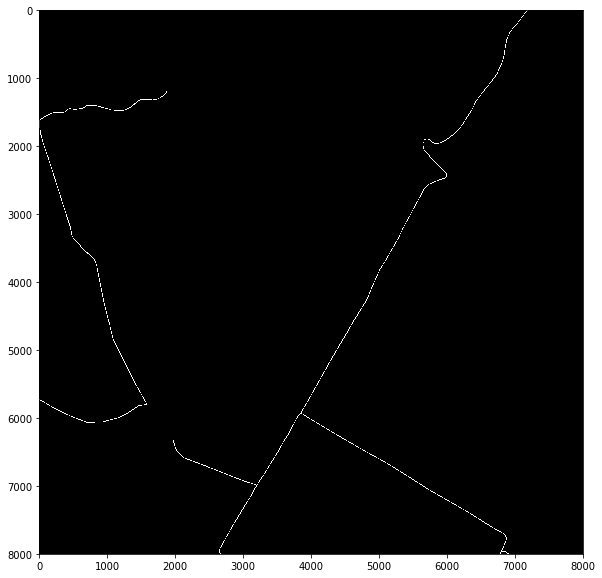

In [0]:
mask = np.zeros((8000,8000,3), np.uint8)
for points in pxl_polygon:
  pts = np.array(points, np.int32)
  pts = pts.reshape((-1,1,2))
  cv2.polylines(mask,[pts],False, (255,255,255), thickness = 10);

plt.figure(figsize=(20,10))
plt.imshow(mask)

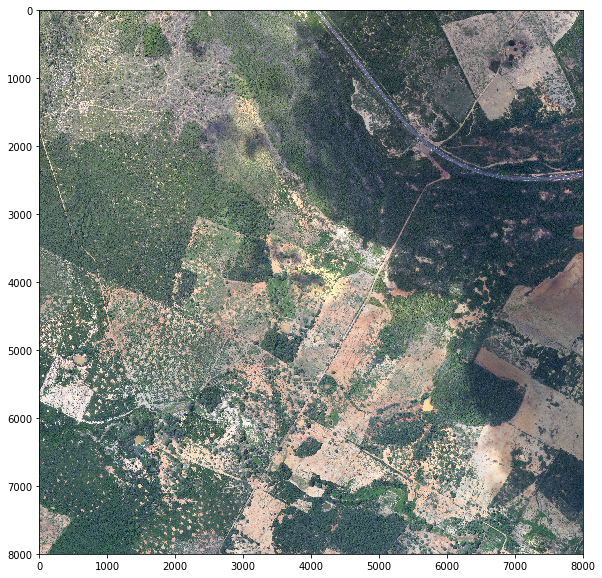

In [0]:
img = cv2.imread("007.jpg")


plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

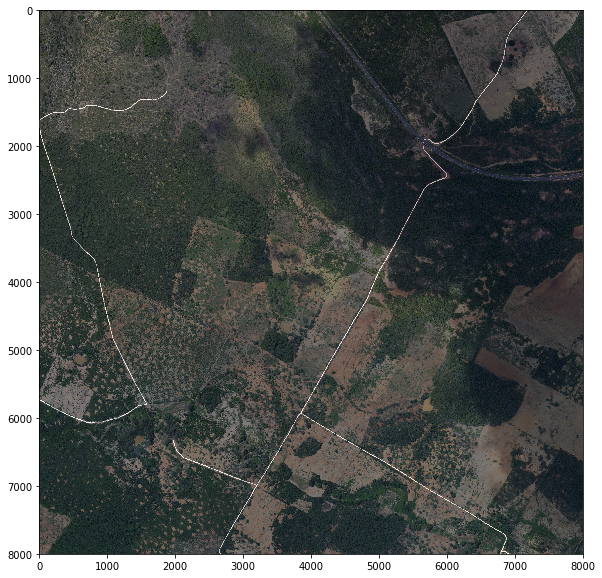

In [0]:
# overlay = img.copy()
# for points in pxl_polygon:
#   pts = np.array(points, np.int32)
#   pts = pts.reshape((-1,1,2))
#   cv2.polylines(overlay,[pts], False, (0, 255, 0), thickness = 40);

opacity = 0.5
cv2.addWeighted(mask, opacity, img, 1 - opacity, 0, img)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [0]:
cv2.imwrite('./test_mask_secroad.jpg', img)

True

### Transforming all coordinates to pixel

In [0]:
from tqdm import tqdm

In [0]:
img_polygons_pxl = {}

for index in tqdm(img_polygons.keys()):
  pxl_polygon = []
  for polygon in img_polygons[index]:
    coords = []
    for coord in polygon:
      coords.append(tuple(coordinate2pixel(coord, df_img_info.loc[index]).reshape(1, -1).astype(int)[0]))
    pxl_polygon.append(coords)
  img_polygons_pxl[index] = pxl_polygon

100%|██████████| 566/566 [00:03<00:00, 171.50it/s]


## Creating Masks

In [0]:
kernel = np.ones((5,5),np.uint8)

for name, polygons in tqdm(img_polygons_pxl.items()):
    mask = np.zeros((8000,8000,3), np.uint8)
    for points in polygons:
        pts = np.array(points, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(mask,[pts], False, (255,255,255), thickness = 10);
    
    mask = cv2.erode(mask,kernel,iterations = 6)
    cv2.imwrite('./masks/Chapada/vias secundarias/'+name.split('.')[0]+'.jpg', mask)

100%|██████████| 566/566 [08:30<00:00,  1.13it/s]
